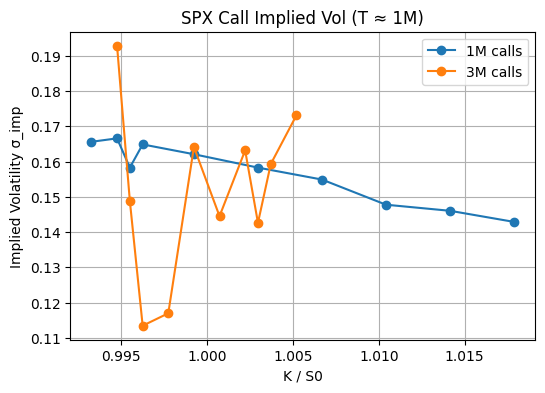

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy import stats

obs_date = "2025-11-24"
S0 = 6705.12
r = 0.05


def bs_call_price(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    Nd1 = stats.norm.cdf(d1)
    Nd2 = stats.norm.cdf(d2)
    value = S0 * Nd1 - K * exp(-r * T) * Nd2
    return value


def bs_vega(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    pdf_d1 = stats.norm.pdf(d1, 0.0, 1.0)
    vega = S0 * pdf_d1 * sqrt(T)
    return vega


def newton_iv(S0, K, T, r, C_mkt, sigma0=0.2, tol=1e-6, it_max=100):
    sigma = sigma0
    for i in range(it_max):
        price = bs_call_price(S0, K, T, r, sigma)
        vega = bs_vega(S0, K, T, r, sigma)
        diff = price - C_mkt   # C_BS(σ) - C_mkt
        if abs(diff) < tol:
            break
        sigma = sigma - diff / vega
    return sigma


def compute_iv_for_calls(file_name, expiry):

    T = (pd.to_datetime(expiry) - pd.to_datetime(obs_date)).days / 365.0


    df = pd.read_csv(file_name)


    df["K"] = df["Strike"]
    df["C_mkt"] = df["Last Price"]
    df["K_over_S0"] = df["K"] / S0

 
    df["sigma_imp"] = df.apply(
        lambda row: newton_iv(
            S0=S0,
            K=row["K"],
            T=T,
            r=r,
            C_mkt=row["C_mkt"],
            sigma0=0.2
        ),
        axis=1
    )
    return df


exp_1M = "2025-12-24"
file_1M = "call 1 month(in).csv"   
exp_3M = "2026-2-27"
file_3M = "3 call.csv" 
df_1M = compute_iv_for_calls(file_1M, exp_1M)
df_3M = compute_iv_for_calls(file_3M, exp_3M)

plt.figure(figsize=(6, 4))
plt.plot(df_1M["K_over_S0"], df_1M["sigma_imp"], marker="o", label="1M calls")
plt.plot(df_3M["K_over_S0"], df_3M["sigma_imp"], marker="o", label="3M calls")
plt.xlabel("K / S0")
plt.ylabel("Implied Volatility σ_imp")
plt.title("SPX Call Implied Vol (T ≈ 1M)")
plt.grid(True)
plt.legend() 
plt.show()
